# Calculating the Ellipticity-Ellipticity Galaxy-Mass Correlation Functions

### Spencer Everett, SLAC, 7/16/2015

First import all of the necessary files:

In [1]:
%load_ext autoreload
%autoreload 2

In [39]:
import numpy as np
import scipy as sp
import os,sys
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import cmath
import treecorr
import copy
%matplotlib inline

In [3]:
# Pangloss:
PANGLOSS_DIR = os.path.expandvars("$PANGLOSS_DIR")
sys.path.append(PANGLOSS_DIR)
import pangloss

In [4]:
K = pangloss.Kappamap(PANGLOSS_DIR+'/data/GGL_los_8_0_0_N_4096_ang_4_rays_to_plane_37_f.kappa.fits')

In [8]:
S = pangloss.Shearmap([PANGLOSS_DIR+'/data/GGL_los_8_0_0_N_4096_ang_4_rays_to_plane_37_f.gamma_1',PANGLOSS_DIR+'/data/GGL_los_8_0_0_N_4096_ang_4_rays_to_plane_37_f.gamma_2'],FITS=False)

In [6]:
#config = pangloss.Configuration(PANGLOSS_DIR+'/example/example.config')
#F = pangloss.ForegroundCatalog(PANGLOSS_DIR+'/data/GGL_los_8_0_0_0_0_N_4096_ang_4_Guo_galaxies_on_plane_27_to_63.images.txt',config)

## Using the module directly:

In [9]:
d=[1.9,-1.9,-1.9,1.9]
#d = [1.9,1.8,-1.9,-1.8]
B = pangloss.BackgroundCatalog(sigma_e=0.2,domain=d)
B.lens_by_map(K,S)
galaxies = B.galaxies
print B.galaxy_count

519840


In [11]:
# Need this to remove galaxies not contained in the K/S maps:
#galaxies = [B.galaxies[i] for i in range(B.galaxy_count) if not np.isnan(B.galaxies[i]).any()]
#print np.shape(galaxies)
print 'min: ',min(galaxies['RA']),'max: ',max(galaxies['RA'])

min:  -0.0331612416338 max:  0.0331612260118


### Ellipticities:

In [15]:
binsize = 0.1
min_sep = 0.5
max_sep = 30

#N = 30
#binsize = np.log10(max_sep/min_sep)/N

cat_int = treecorr.Catalog(ra=galaxies['RA'], dec=galaxies['Dec'], g1=galaxies['e1_int'], g2=galaxies['e2_int'], ra_units='rad', dec_units='rad')
gg_int = treecorr.GGCorrelation(bin_size=binsize, min_sep=min_sep, max_sep=max_sep, sep_units='arcmin', bin_slop=0.05/binsize)
gg_int.process(cat_int)

cat = treecorr.Catalog(ra=galaxies['RA'], dec=galaxies['Dec'], g1=galaxies['e1'], g2=galaxies['e2'], ra_units='rad', dec_units='rad')
gg = treecorr.GGCorrelation(bin_size=binsize, min_sep=min_sep, max_sep=max_sep, sep_units='arcmin', bin_slop=0.05/binsize)
gg.process(cat)

## xi_+ and xi_x Correlation

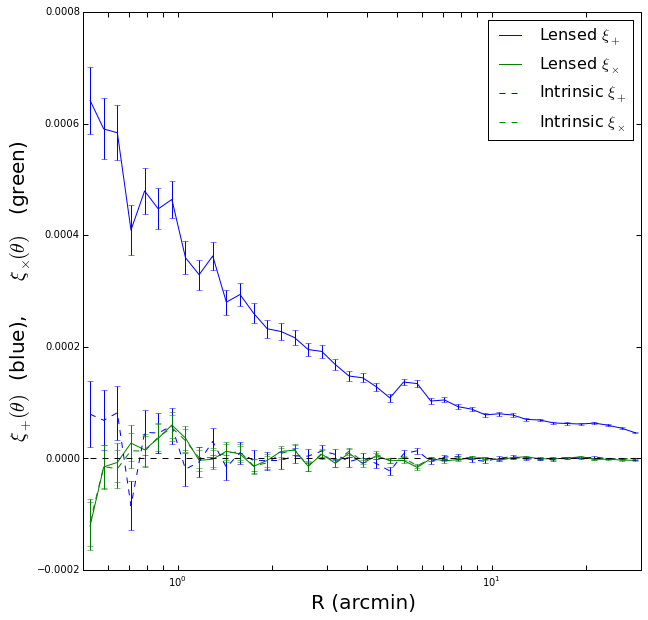

In [45]:
# Pres plot 1
plt.errorbar(np.exp(gg.logr), gg.xip, np.sqrt(gg.varxi), c='b')
plt.errorbar(np.exp(gg.logr), 0.5*(gg.xip_im+gg.xim_im), 0.5*np.sqrt(gg.varxi+gg.varxi), c='g')
plt.errorbar(np.exp(gg_int.logr), gg_int.xip, np.sqrt(gg_int.varxi), c='b', linestyle='dashed')
plt.errorbar(np.exp(gg_int.logr), 0.5*(gg_int.xip_im+gg_int.xim_im), 0.5*np.sqrt(gg_int.varxi+gg_int.varxi), c='g', linestyle='dashed')
plt.plot([min(np.exp(gg.logr)),max(np.exp(gg.logr))],[0,0],c='k',linestyle='dashed')

# Make axis ticks larger
plt.gca().tick_params('both', length=5, width=1, which='major')
plt.gca().tick_params('both', length=5, width=1, which='minor')

# Plot settings
plt.xscale('log')
plt.ylabel(r'$\xi_+(\theta)\,\,$'+ '(blue), '+r'$\quad\xi_\times(\theta)\,\,$'+' (green)',fontsize=20)
plt.xlabel('R (arcmin)',fontsize=20)
plt.gcf().set_size_inches(10,10)
plt.gca().set_xlim(min_sep,max_sep)
plt.legend([r'Lensed $\xi_+$',r'Lensed $\xi_\times$',r'Intrinsic $\xi_+$',r'Intrinsic $\xi_\times$'],fontsize=16)

# Set figure size
plt.gcf().set_size_inches(10,10)

In [ ]:
# Pres plot 2
plt.errorbar(np.exp(gg.logr), 0.5*(gg.xip_im+gg.xim_im), 0.5*np.sqrt(gg.varxi+gg.varxi), c='g')
plt.errorbar(np.exp(gg_int.logr), 0.5*(gg_int.xip_im+gg_int.xim_im), 0.5*np.sqrt(gg_int.varxi+gg_int.varxi), c='g', linestyle='dashed')
plt.plot([min(np.exp(gg.logr)),max(np.exp(gg.logr))],[0,0],c='k',linestyle='dashed')
plt.gca().tick_params('both', length=5, width=1, which='major')
plt.gca().tick_params('both', length=5, width=1, which='minor')

plt.xscale('log')
plt.ylabel(r'$\quad\xi_\times(\theta)$',fontsize=20)
plt.xlabel('R (arcmin)',fontsize=20)
plt.gcf().set_size_inches(10,10)
plt.gca().set_xlim(min_sep,max_sep)
#plt.title('Ellipticity-Ellipticity, bin_size = '+str(binsize))
plt.legend([r'Lensed $\xi_\times$',r'Intrinsic $\xi_\times$'],fontsize=16)

## Correlation with noise

In [41]:
# Domain size
d=[1.9,-1.9,-1.9,1.9]

B1 = pangloss.BackgroundCatalog(sigma_e=0.2,domain=d)
B1.lens_by_map(K,S)
B2 = copy.deepcopy(B1)
B3 = copy.deepcopy(B1)

B1.add_noise(M=1.0)
galaxies1 = B1.galaxies

B2.add_noise(M=0.9)
galaxies2 = B2.galaxies

B3.add_noise(M=0.8)
galaxies3 = B3.galaxies

'''
B2 = pangloss.BackgroundCatalog(sigma_e=0.2,domain=d)
B2.lens_by_map(K,S)
B2.add_noise(M=0.8)
galaxies2 = B2.galaxies

B3 = pangloss.BackgroundCatalog(sigma_e=0.2,domain=d)
B3.lens_by_map(K,S)
B3.add_noise(M=0.6)
galaxies3 = B3.galaxies
'''

'\nB2 = pangloss.BackgroundCatalog(sigma_e=0.2,domain=d)\nB2.lens_by_map(K,S)\nB2.add_noise(M=0.8)\ngalaxies2 = B2.galaxies\n\nB3 = pangloss.BackgroundCatalog(sigma_e=0.2,domain=d)\nB3.lens_by_map(K,S)\nB3.add_noise(M=0.6)\ngalaxies3 = B3.galaxies\n'

In [42]:
binsize = 0.1
min_sep = 0.5
max_sep = 30

cat1 = treecorr.Catalog(ra=galaxies1['RA'], dec=galaxies1['Dec'], g1=galaxies1['e1'], g2=galaxies1['e2'], ra_units='rad', dec_units='rad')
gg1 = treecorr.GGCorrelation(bin_size=binsize, min_sep=min_sep, max_sep=max_sep, sep_units='arcmin', bin_slop=0.05/binsize)
gg1.process(cat1)

cat2 = treecorr.Catalog(ra=galaxies2['RA'], dec=galaxies2['Dec'], g1=galaxies2['e1'], g2=galaxies2['e2'], ra_units='rad', dec_units='rad')
gg2 = treecorr.GGCorrelation(bin_size=binsize, min_sep=min_sep, max_sep=max_sep, sep_units='arcmin', bin_slop=0.05/binsize)
gg2.process(cat2)

cat3 = treecorr.Catalog(ra=galaxies3['RA'], dec=galaxies3['Dec'], g1=galaxies3['e1'], g2=galaxies3['e2'], ra_units='rad', dec_units='rad')
gg3 = treecorr.GGCorrelation(bin_size=binsize, min_sep=min_sep, max_sep=max_sep, sep_units='arcmin', bin_slop=0.05/binsize)
gg3.process(cat3)

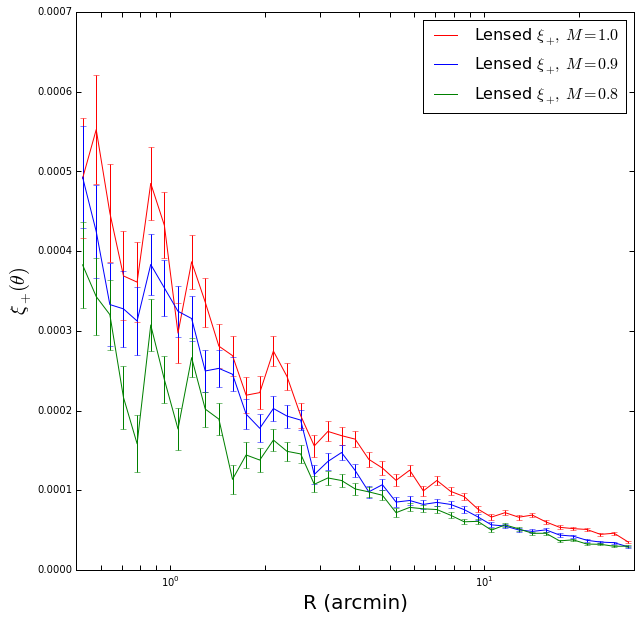

In [44]:
# Pres plot 1
plt.errorbar(np.exp(gg1.logr), gg1.xip, np.sqrt(gg1.varxi), c='r')
plt.errorbar(np.exp(gg2.logr), gg2.xip, np.sqrt(gg2.varxi), c='b')
plt.errorbar(np.exp(gg3.logr), gg3.xip, np.sqrt(gg3.varxi), c='g')
plt.plot([min(np.exp(gg1.logr)),max(np.exp(gg1.logr))],[0,0],c='k',linestyle='dashed')

# Make axis ticks larger
plt.gca().tick_params('both', length=5, width=1, which='major')
plt.gca().tick_params('both', length=5, width=1, which='minor')

# Plot settings
plt.xscale('log')
plt.ylabel(r'$\xi_+(\theta)$',fontsize=20)
plt.xlabel('R (arcmin)',fontsize=20)
plt.gcf().set_size_inches(10,10)
plt.gca().set_xlim(min_sep,max_sep)
plt.legend([r'Lensed $\xi_+,\,M=1.0$',r'Lensed $\xi_+,\,M=0.9$',r'Lensed $\xi_+,\,M=0.8$'],fontsize=16)

### Galaxy-Mass:

In [ ]:
B = pangloss.BackgroundCatalog(sigma_e=0.2,domain=[1.9,-1.9,-1.9,1.9])
B.lens_by_map(K,S)
print B.galaxy_count

In [ ]:
galaxies = B.galaxies

In [ ]:
ra = np.rad2deg(galaxies['RA'])
dec = np.rad2deg(galaxies['Dec'])

In [ ]:
min_sep = 0.01
max_sep = 1.0
N = 10
binsize = np.log10(max_sep/min_sep)/N

In [ ]:
cat1 = treecorr.Catalog(ra=ra, dec=dec, ra_units='deg', dec_units='deg')
cat2 = treecorr.Catalog(ra=ra, dec=dec, g1=galaxies['e1_int'], g2=galaxies['e2_int'], ra_units='deg', dec_units='deg')
ng = treecorr.NGCorrelation(bin_size=binsize, min_sep=min_sep, max_sep=max_sep, sep_units='deg', bin_slop=0.05/binsize)
ng.process(cat1,cat2)

In [ ]:
plt.errorbar(np.exp(ng.logr), ng.xi, np.sqrt(ng.varxi), c='k')
plt.errorbar(np.exp(ng.logr), ng.xi, np.sqrt(ng.varxi), c='g')
plt.xscale('log')
plt.ylabel(r'$\xi$')
plt.xlabel('R (deg)')
plt.gcf().set_size_inches(10,10)
plt.gca().set_xlim(min_sep,max_sep)
plt.title('N-G, bin_size = '+str(binsize))